In [6]:
from tbparse import SummaryReader
log_dir = "/scratch-shared/scur2012/trained_models/unet_softloss/tb_logs"
reader = SummaryReader(log_dir)
df = reader.scalars
print(df)

          step                 tag     value
0           49               epoch  0.000000
1           99               epoch  0.000000
2          149               epoch  0.000000
3          199               epoch  0.000000
4          249               epoch  0.000000
...        ...                 ...       ...
102096  147922  val_loss_feature_9 -0.275398
102097  149339  val_loss_feature_9 -0.277619
102098  150339  val_loss_feature_9 -0.278178
102099  151339  val_loss_feature_9 -0.271850
102100  152339  val_loss_feature_9 -0.277584

[102101 rows x 3 columns]


In [7]:
import duckdb

intrinsic_variables = ['mass_ratio', 'chirp_mass', 'theta_jn', 'phase', 'tilt_1', 'tilt_2', 'a_1', 'a_2', 'phi_12', 'phi_jl']
extrinsic_variables = ['luminosity_distance', 'dec', 'ra', 'psi', 'geocent_time']

with duckdb.connect(database=':memory:') as conn:
    df_main = conn.execute("""
        SELECT * 
        FROM df 
        WHERE tag = 'train_loss' OR tag = 'val_loss'
    """).df()
    
    df_val_loss_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'val_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'val_loss_feature%'
    """).df()

    df_train_loss_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'train_loss_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'train_loss_feature%'
    """).df()

    df_val_auc_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'val_auc_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'val_loss_feature%'
    """).df()

    df_train_auc_features = conn.execute(f"""
        SELECT step, value,
        CASE 
            {" ".join([f"WHEN tag = 'train_auc_feature_{i}' THEN '{name}'" for i,name in enumerate(
                intrinsic_variables+extrinsic_variables)])}
        END AS feature
        FROM df 
        WHERE tag LIKE 'train_loss_feature%'
    """).df()

    df_features2 = conn.execute("""
        SELECT * 
        FROM df_val_loss_features 
        WHERE feature IN (
            SELECT feature
            FROM df_val_loss_features
            GROUP BY feature
            HAVING MIN(value) < -0.3
        )
    """).df()
    df_features1 = conn.execute("""
        SELECT * 
        FROM df_val_loss_features 
        WHERE feature IN (
            SELECT feature
            FROM df_val_loss_features
            GROUP BY feature
            HAVING MIN(value) BETWEEN -0.3 AND -0.005
        )
    """).df()
    
df_features1

,step,value,feature
0,999,-0.153314,luminosity_distance
1,1999,-0.166703,luminosity_distance
2,2999,-0.191131,luminosity_distance
3,3999,-0.196327,luminosity_distance
4,4999,-0.198219,luminosity_distance
...,...,...,...
1291,147922,-0.275398,phi_jl
1292,149339,-0.277619,phi_jl
1293,150339,-0.278178,phi_jl
1294,151339,-0.271850,phi_jl


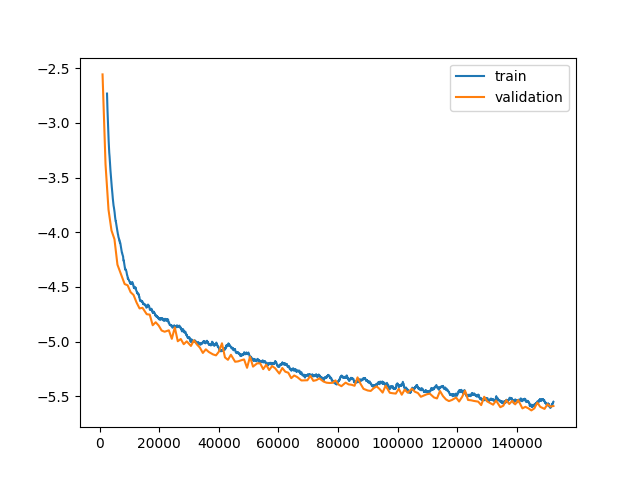

In [8]:
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

train_loss = df_main[df_main['tag'] == 'train_loss'].copy()
train_loss['smoothed'] = train_loss['value'].rolling(50).mean()
val_loss = df_main[df_main['tag'] == 'val_loss']

plt.close(1), plt.figure(1)
plt.plot(train_loss['step'], train_loss['smoothed'], label='train')
plt.plot(val_loss['step'], val_loss['value'], label='validation')
plt.legend()

plt.show()

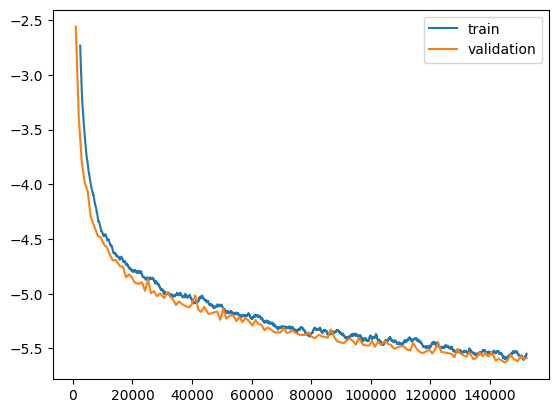

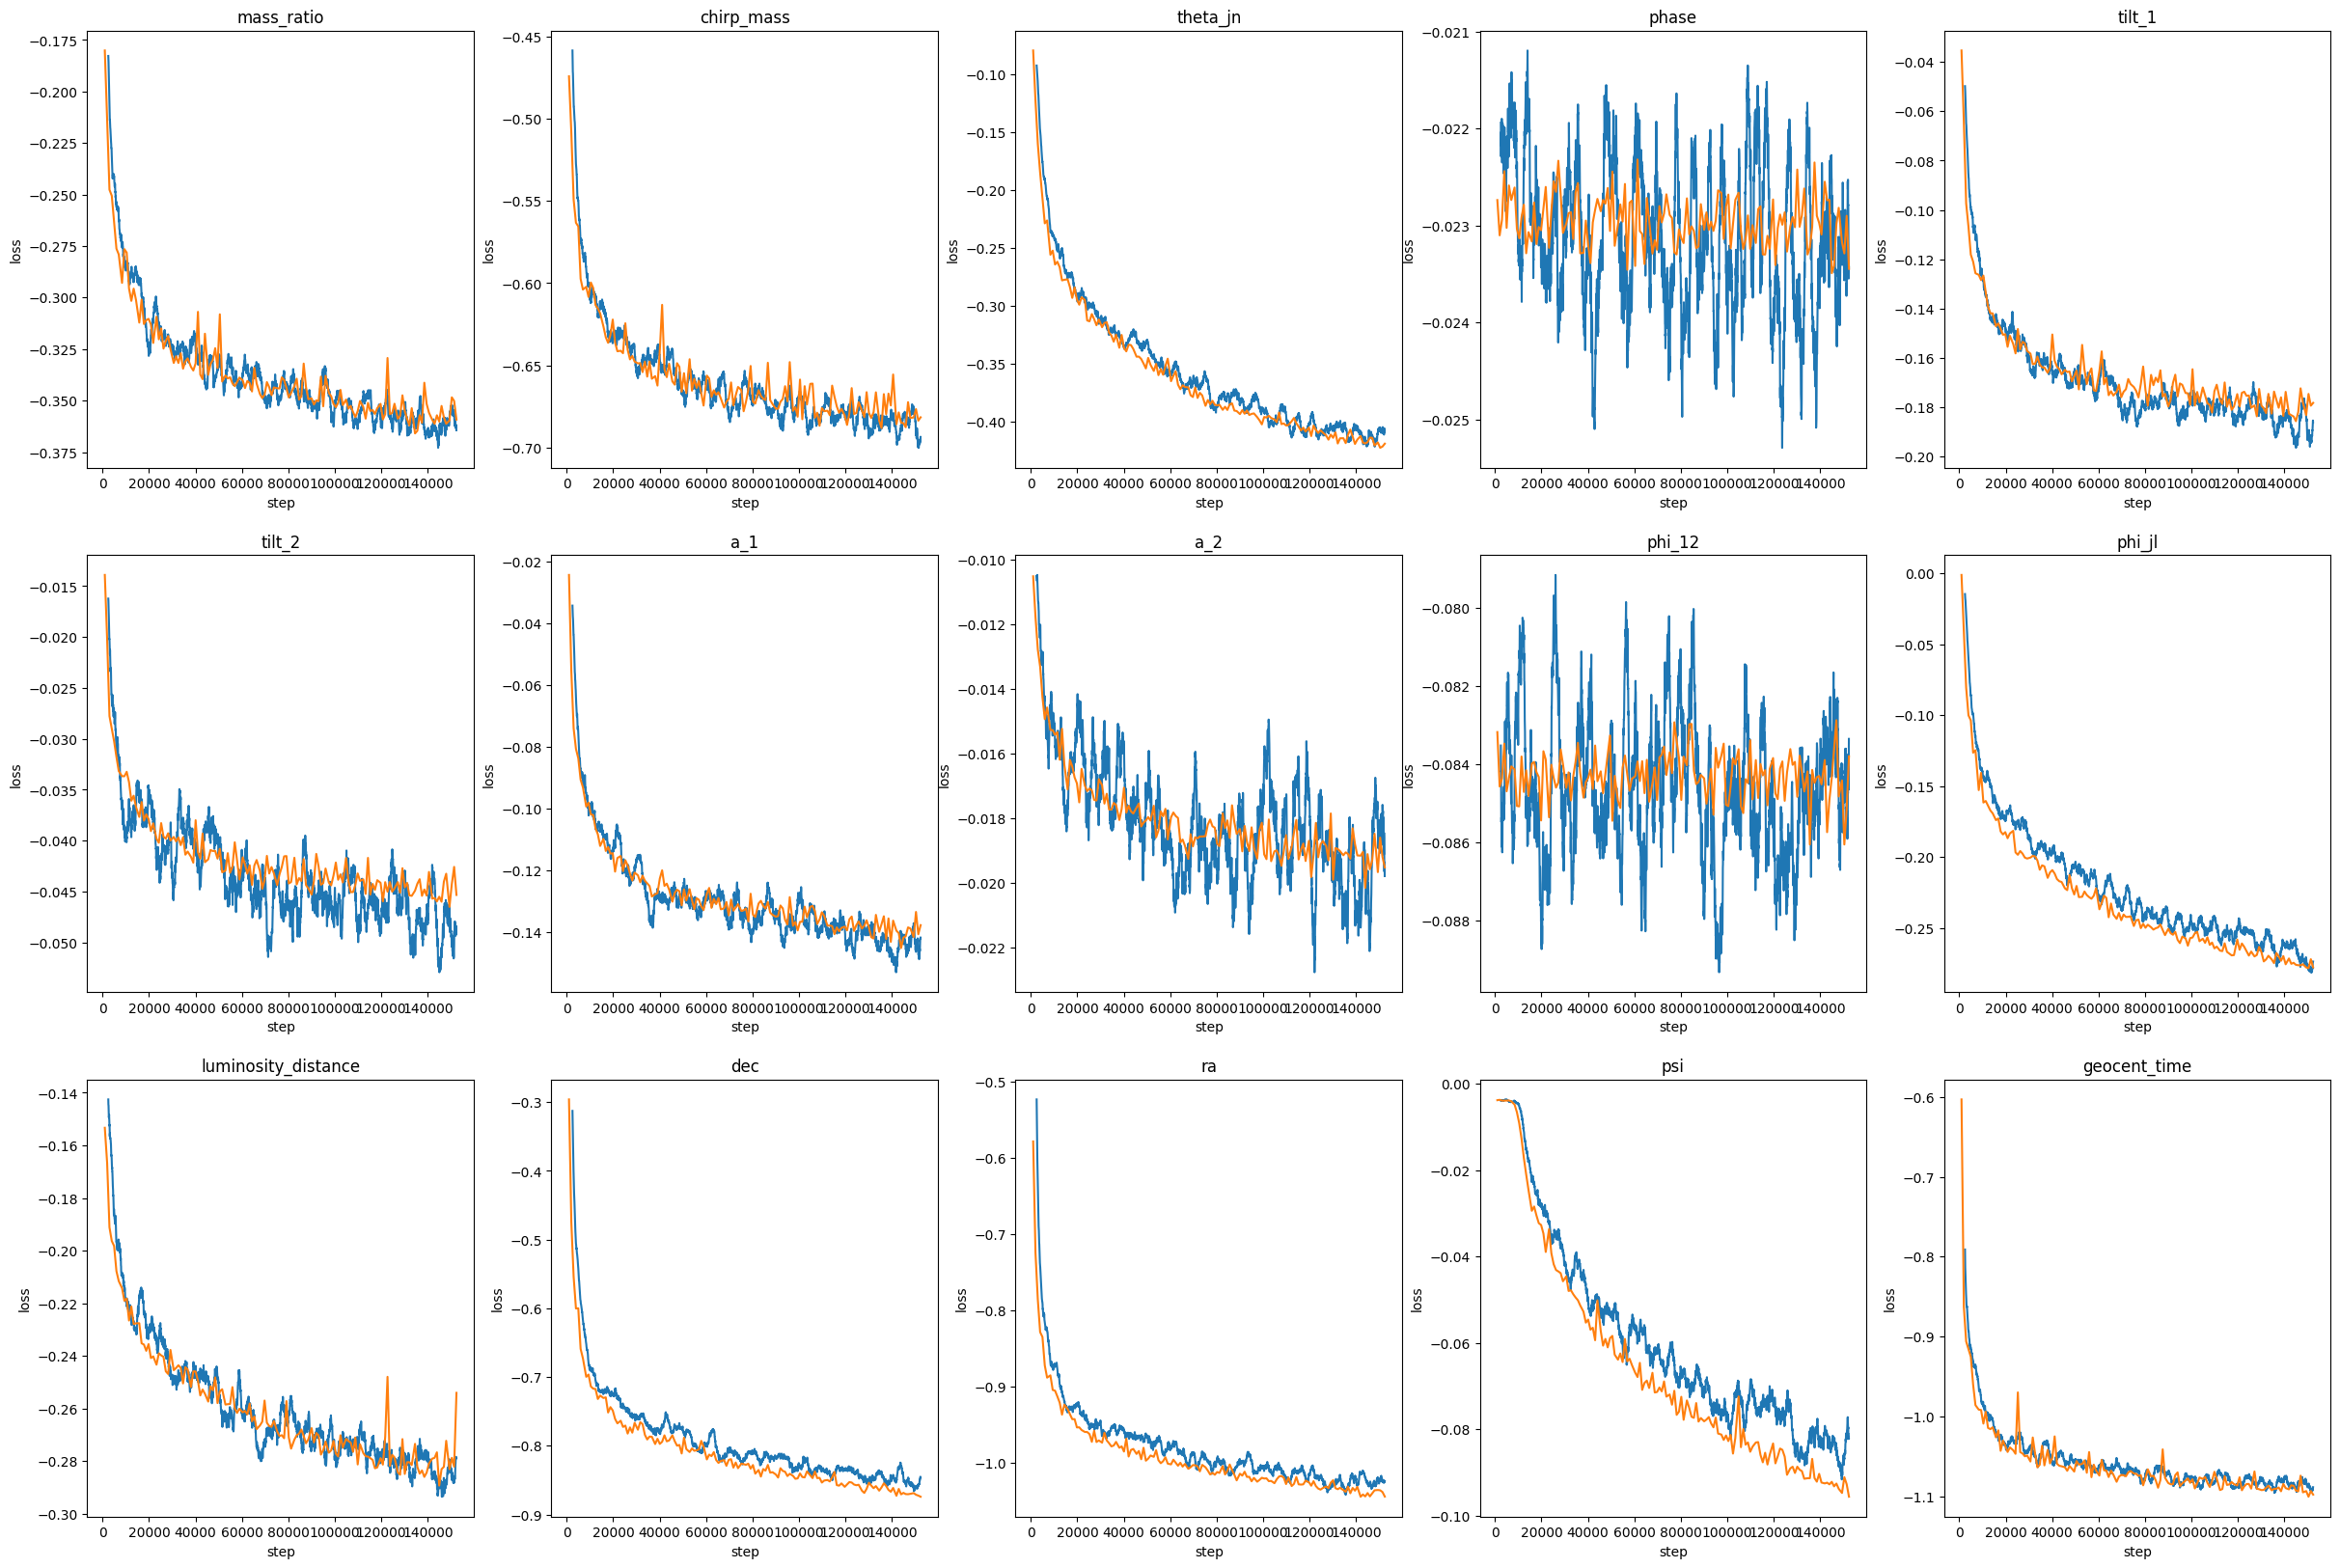

No such comm: 7648e9e46a094f1bb73e363ae5e9577d


In [9]:
%matplotlib inline

plt.figure(2, figsize=(30, 20))
        
# Intrinsic variables plotting
for i, name in enumerate(intrinsic_variables+extrinsic_variables):
    ax = plt.subplot(3, 5, i + 1)
    plt.xlabel('step')
    plt.ylabel('loss')
    
    train_data = df_train_loss_features[df_train_loss_features['feature']==name].copy()
    train_data['smoothed'] = train_data['value'].rolling(50).mean()
    
    val_data = df_val_loss_features[df_val_loss_features['feature']==name]
    
    plt.title(name)
    plt.plot(train_data['step'], train_data['smoothed'], label='train')
    plt.plot(val_data['step'], val_data['value'], label='val')

<Axes: xlabel='step', ylabel='value'>

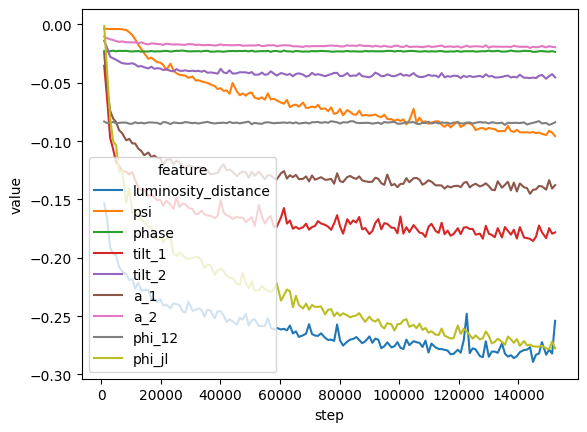

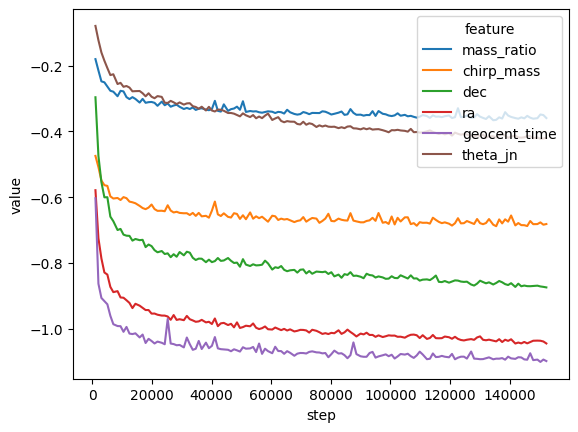

In [10]:
%matplotlib inline

plt.close(2), plt.figure(2)
sns.lineplot(data=df_features1, x='step', y='value', hue='feature')

plt.close(3), plt.figure(3)
sns.lineplot(data=df_features2, x='step', y='value', hue='feature')